In [1]:
import numpy as np

from astropy import units as u
from astropy import constants as c

import camb
import emcee
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
lmax = 2500

def load_planck_data(file_path):
    data = np.loadtxt(file_path, skiprows=1)
    ell = data[:lmax+1, 0]
    tt = data[:lmax+1, 1]
    return ell, tt

In [3]:
file_path = "data/COM_PowerSpect_CMB_R3.01.txt"
ell_tt_clean, cl_tt_clean = load_planck_data(file_path)

In [4]:
# This function takes a set of cosmological parameters as input and returns the 
# temperature power spectrum (TT) computed using the CAMB library. It sets the necessary 
# cosmological and initial power parameters and configures the maximum multipole moment lmax 
# for the computation. Finally, it extracts the TT spectrum from the obtained power spectra.
def get_power_spectrum(params):
    H0, ombh2, omch2, tau, As, ns = params
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=0.06, omk=0, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, r=0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    return powers['total'][:lmax + 1, 0]  # Use only the TT spectrum up to lmax


# It takes the input cosmological parameters and the power spectrum data (in this case, 
# obtained from the input FITS file) and computes the log-likelihood using the chi-squared statistic. 
# It first calculates the power spectrum using the get_power_spectrum function, then computes the 
# chi-squared value by summing the squared differences between the data and the model, normalized by the model. 
# Finally, it returns the negative half of the chi-squared value as the log-likelihood.
def log_likelihood(params, cl_data):
    model = get_power_spectrum(params)
    diff = cl_data[2:] - model[2:]  # Exclude monopole and dipole terms (l=0 and l=1)
    chi2 = np.sum(diff ** 2 / model[2:])  # Use the model as an estimate for the error
    return -0.5 * chi2


# This function takes the input cosmological parameters and checks if they fall within reasonable ranges. 
# If the parameters are within the specified ranges, the function returns a log prior probability of 0, 
# indicating that the parameters have equal probability. If any parameter falls outside the specified range, 
# the function returns a log prior probability of negative infinity, indicating that the parameter combination 
# is not allowed.
def log_prior(params):
    H0, ombh2, omch2, tau, As, ns = params
    if 50 < H0 < 100 and 0.01 < ombh2 < 0.1 and 0.01 < omch2 < 0.7 and 0.01 < tau < 0.8 and 1e-10 < As < 1e-8 and 0.8 < ns < 1.2:
        return 0.0
    return -np.inf


# This function combines the log prior and log likelihood functions to compute the overall log probability.
# First, it calculates the log prior using the log_prior function. If the log prior is not finite 
# (i.e., if it is -np.inf), the function returns -np.inf, indicating that the parameter combination is not allowed. 
# Otherwise, it adds the log likelihood (computed using the log_likelihood function) to the log prior and returns 
# the resulting log probability.
def log_probability(params, cl_data):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, cl_data)



In [5]:
# Set up and run the emcee sampler
n_walkers, n_dim = 32, 6
initial_guess = [67.5, 0.022, 0.122, 0.06, 2e-9, 0.965]
pos = np.array(initial_guess) * (1 + 0.01 * np.random.randn(n_walkers, n_dim))
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(cl_tt_clean,))
sampler.run_mcmc(pos, 2000, progress=True)

100%|█████████████████████████████████████| 2000/2000 [7:05:27<00:00, 12.76s/it]


State([[6.64112044e+01 2.23613348e-02 1.24805482e-01 1.54931203e-02
  1.97001690e-09 9.54340913e-01]
 [6.66446276e+01 2.22305517e-02 1.24419962e-01 1.25086716e-02
  1.95914260e-09 9.55824830e-01]
 [6.63060139e+01 2.22638485e-02 1.25081159e-01 1.32168575e-02
  1.96343597e-09 9.53987099e-01]
 [6.59876465e+01 2.21889460e-02 1.25675386e-01 1.14551089e-02
  1.95756246e-09 9.53590197e-01]
 [6.65779914e+01 2.21903100e-02 1.23784595e-01 1.14896132e-02
  1.94961934e-09 9.54985819e-01]
 [6.63477353e+01 2.23243456e-02 1.25051046e-01 1.35831636e-02
  1.96394174e-09 9.53808288e-01]
 [6.61138235e+01 2.22328657e-02 1.25304222e-01 1.00809481e-02
  1.94859292e-09 9.53067853e-01]
 [6.61935927e+01 2.21674426e-02 1.25640394e-01 1.27880862e-02
  1.96558681e-09 9.53151124e-01]
 [6.61828375e+01 2.21969738e-02 1.25403758e-01 1.04243828e-02
  1.95308400e-09 9.52696050e-01]
 [6.68451240e+01 2.23644546e-02 1.24185214e-01 1.73332319e-02
  1.97333711e-09 9.55884916e-01]
 [6.69867034e+01 2.24370851e-02 1.23911589e-

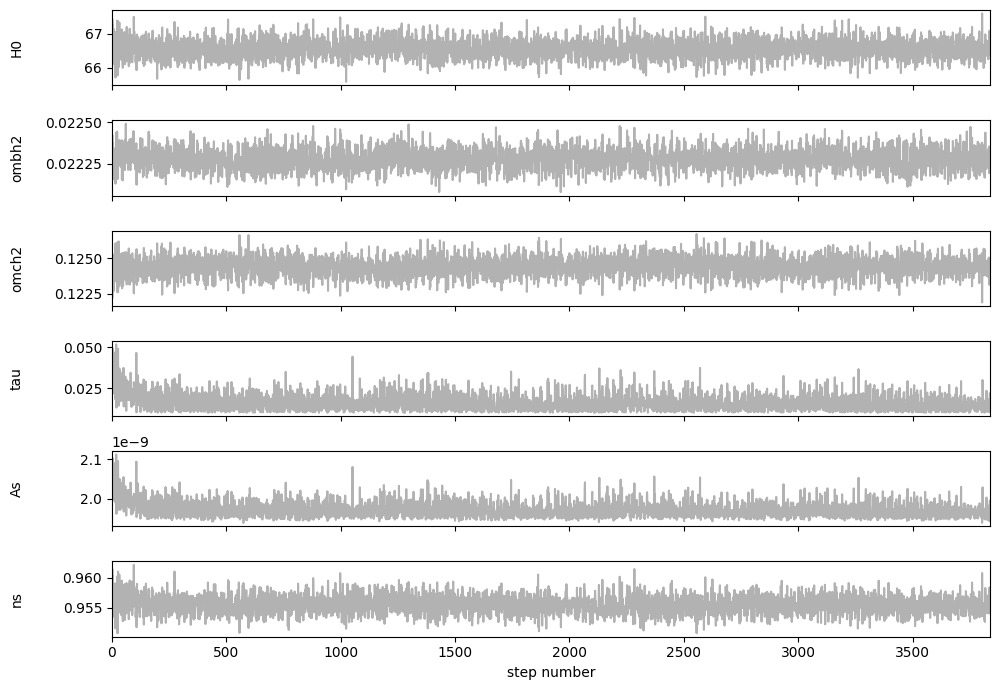

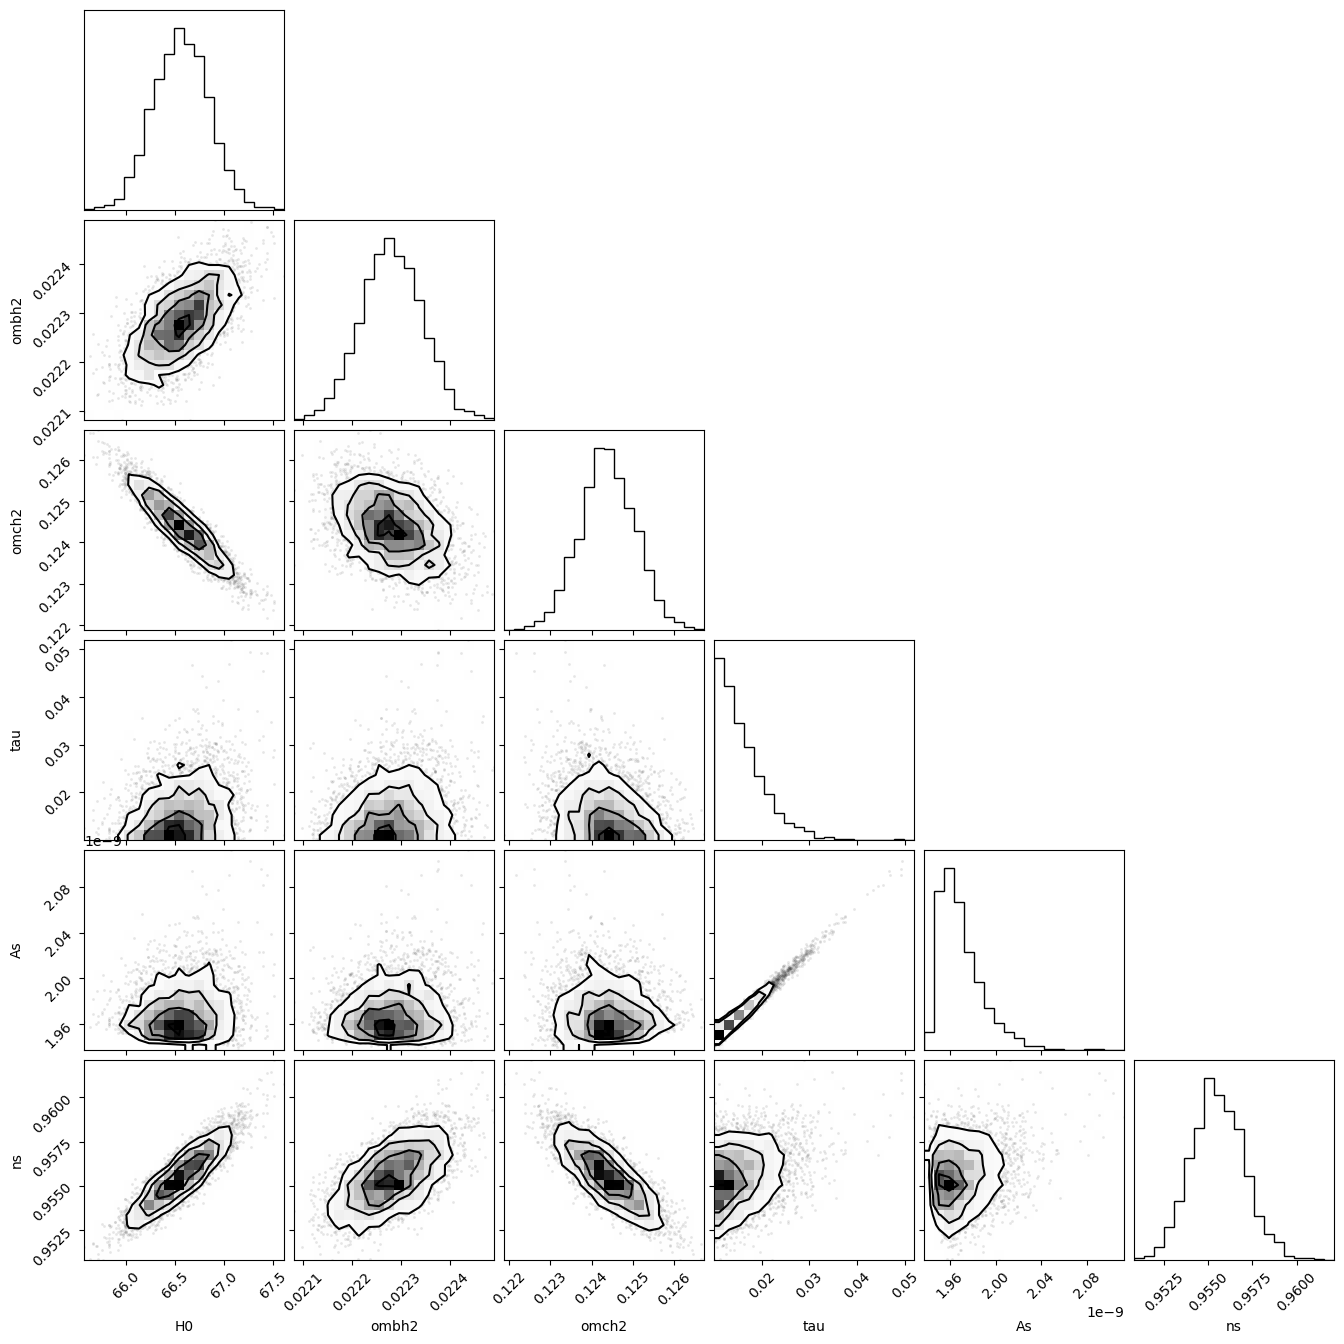

H0: 66.6 +0.278 -0.285
ombh2: 0.0223 +6.29e-05 -6.1e-05
omch2: 0.124 +0.000688 -0.000645
tau: 0.0147 +0.00593 -0.00336
As: 1.97e-09 +2.24e-11 -1.26e-11
ns: 0.956 +0.00149 -0.00143


In [6]:
# Analyze the results
samples = sampler.get_chain(discard=200, thin=15, flat=True)
labels = ["H0", "ombh2", "omch2", "tau", "As", "ns"]

# Plot the trace of each parameter
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
for i, label in enumerate(labels):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(label)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.tight_layout()
plt.show()

# Plot the corner plot to visualize parameter distributions and correlations
import corner
corner.corner(samples, labels=labels)
plt.show()

# Print the median and 1-sigma uncertainties for the parameters
for i, label in enumerate(labels):
    median = np.median(samples[:, i])
    lower, upper = np.percentile(samples[:, i], [16, 84])
    print(f"{label}: {median:.3g} +{upper - median:.3g} -{median - lower:.3g}")
